# Learning to Learn on Fashion MNIST Dataset

### Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
from tqdm import tqdm
import tensorflow_datasets as tfds
import sklearn.metrics as sm
from matplotlib import pyplot as plt

### LSTM Default parameters

In [ ]:
n_parameters = 4 # 2 dense layers and 2 biases
batch_size = 512
num_unroll = 20
hidden_size = 20
num_layers = 2
epochs = 50

### Retrieve and Prepare data

In [ ]:
(train_data, validation_data), info = tfds.load("fashion_mnist", split=['train[:90%]', 'train[90%:]'], with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

Shuffling and writing examples to ./data/fashion_mnist/3.0.1.incompleteD9JCQN/fashion_mnist-train.tfrecord


Shuffling and writing examples to ./data/fashion_mnist/3.0.1.incompleteD9JCQN/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

train_data = train_data.map(format_image)
validation_data = validation_data.map(format_image)

test_data = test_data.map(format_image)

In [ ]:
train = train_data.shuffle(buffer_size=1024).batch(batch_size)


In [ ]:
test_x, test_y = tuple(zip(*test_data))

test_x = np.array(test_x)
test_y = np.array(test_y)

valid_x, valid_y = tuple(zip(*validation_data))

valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

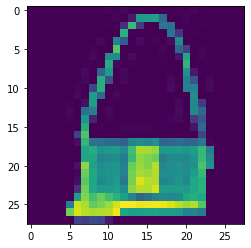

In [ ]:
plt.imshow(valid_x[3].reshape(28,28))
plt.show()

In [ ]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
test_val_accuracy = val_accuracy = sm.accuracy_score
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

### Define custom layers to allow gradient flow

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation=None):
        '''Initializes the instance attributes'''
        super(CustomDense, self).__init__()
        self.units = units
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.initializers.GlorotUniform()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs, weights, bias):
        '''Defines the computation from inputs to outputs'''

        return self.activation(tf.matmul(inputs, weights) + bias)

### Define optimizee network

In [ ]:
class MnistOptimizee(Model):
    def __init__(self, hidden_size=20, activation='tanh'):
        super(MnistOptimizee, self).__init__()
        # Now we initalize the needed layers - order does not matter.
        # -----------------------------------------------------------
        # Flatten Layer
        self.flatten = tf.keras.layers.Flatten()
        # First Dense Layer
        self.dense1 = CustomDense(hidden_size, activation=activation)
        # Output Layer
        self.dense2 = CustomDense(10, activation='softmax')
                        
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.step_training_losses, self.step_validation_losses = [], []
        self.tensor_trainable_weights = self.trainable_weights
    
    def call(self, inputs, tensor_trainable_weights):
        x = self.flatten(inputs)        
        x = self.dense1(x, tensor_trainable_weights[0], tensor_trainable_weights[1])
        classifier = self.dense2(x, tensor_trainable_weights[2], tensor_trainable_weights[3])
        return classifier


### Methods for training the model and optimizer

In [ ]:
# Train Optimizer
def train_optimizer(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data, for_optimizer=True)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))
    
def get_validation_data():
    """
    Helper function to compute and retrieve validation loss and validation accuracy
    """
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)

    # Take the max value after prediction for accuracy metric
    validation_predictions = np.argmax(validation_predictions, axis=1) 
    validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)

    return validation_loss, validation_accuracy


def train_data_for_one_epoch(train_data, for_optimizer=False): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = []
    avg_validation_accuracy = []
    avg_loss = []

    for step, (x_batch_train, y_batch_train) in enumerate(train):
        if for_optimizer:
          if step == 100:  # Add a stop at 100 steps as per original paper description
            break
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)
        model.step_training_losses.append(loss)
        avg_loss.append(loss)

        validation_loss, validation_accuracy = get_validation_data()

        # save per step losses
        model.step_validation_losses.append(validation_loss)

        # store validation data
        avg_validation_loss.append(validation_loss)
        avg_validation_accuracy.append(validation_accuracy) 

        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f val_acc %.3f" % (
            int(step), float(loss), float(validation_loss), float(validation_accuracy)
        ))
        pbar.update()

    avg_loss = np.mean(avg_loss)
    avg_validation_loss = np.mean(avg_validation_loss)
    avg_validation_accuracy = np.mean(avg_validation_accuracy)
    return avg_loss, avg_validation_loss, avg_validation_accuracy

def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                predictions = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.3)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

In [ ]:
# Training the model

def initialize_model(hidden_size=20):
    model.dense1.build((batch_size, 784)) # input data after flatten (28*28)
    model.dense2.build((batch_size, hidden_size))
    model.tensor_trainable_weights = model.trainable_weights

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))

def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        predictions = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]    
        
    return loss

### Define LSTM Optimizer

In [ ]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, n_parameters, batch_size, num_unroll, preprocessing_value=10,**kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.batches = [hidden_size*784, hidden_size, hidden_size*10, 10]
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size, kernel_regularizer=tf.keras.regularizers.l2(l2=0.02)) for i in range(num_layers)])
        self.state_list = []
        self.num_unroll = num_unroll
        self.preprocessing_value = preprocessing_value 
        
    def refresh_state(self): 
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.batches[i], dtype = 'float') for i in range(n_parameters)]
    
    def call(self, gradients):
        parameter_updates = []
        for i in range(n_parameters):
            grad_h_t = gradients[i]  # The gradient of the i-th parameter
            state = self.state_list[i]
            
            try:
                grad_h_t.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                grad_h_t = tf.reshape(grad_h_t, [model.variables[i].shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            
            flattened_grad = tf.reshape(grad_h_t,[-1, ]) # flatten out the gradient to make it compatible with the cell
            # Preprocessing
            preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

            condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
            case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
            case_false1 = -1
            preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

            case_true2 = np.sign(flattened_grad)
            case_false2 = np.exp(self.preprocessing_value) * flattened_grad
            preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)

            cell_output, state = self.lstm_cells(preprocessed_inputs, state)
            self.state_list[i] = state # update the state
            cell_output = self.batch_norm(cell_output)
            parameter_update = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 

            parameter_update = tf.reshape(parameter_update, [grad_h_t.shape[0], grad_h_t.shape[1]]) # reshape the update back to the dimension of the gradients
            parameter_update = parameter_update * 0.05 # rescale final parameters
            parameter_updates.append(parameter_update)
        
        parameter_updates[1] = tf.squeeze(parameter_updates[1]) # biases
        parameter_updates[3] = tf.squeeze(parameter_updates[3]) # biases

        return parameter_updates

## Train optimizer and model

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=hidden_size, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model = MnistOptimizee(hidden_size=20)
initialize_model()

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 99: 0.3537 val_loss 0.5998 val_acc 0.826:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 0.4464 ,avg_val_loss: 0.6512 avg_val_acc: 0.7916, current_val_Acc 0.8258 



In [ ]:
# Initialize the model to test trained LSTM optimizer's performance 
model = MnistOptimizee(hidden_size=20)
initialize_model()

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.5494 val_loss 0.6102 val_acc 0.784: 100%|██████████| 106/106 



 Epoch: 0 => loss: 0.9295 ,avg_val_loss: 0.9103 avg_val_acc: 0.6830, current_val_Acc 0.7840 



## Hand Crafted Optimizers Train and Test

In [ ]:
class NormalMnistModel(tf.keras.Model):

    def __init__(self):
        super(NormalMnistModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        return self.dense2(x)
    


In [ ]:
def train_data_for_one_epoch_hand_crafted(model, optimizer, steps=None, steps_limit=None):
  # store per step
  step_train_losses, step_valid_losses = [], []

  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      if steps_limit:
        if steps == steps_limit:
        # if we reach defined number of steps break
          break
        else:
          steps += 1

      logits, loss_value = apply_gradient_hand_crafted_models(model, optimizer, x_batch_train, y_batch_train)
      
      step_train_losses.append(loss_value)
      valid_losses, validation_accuracy = perform_validation(model)
      step_valid_losses.append(valid_losses)

      pbar.set_description("Training loss for step %s: %.4f, validation loss: %.4f, validation accuracy: %.4f" % (int(step), float(loss_value), float(valid_losses), float(validation_accuracy)))
      pbar.update()

  return step_train_losses, step_valid_losses, steps

In [ ]:
def perform_validation(model):
  val_logits = model(valid_x)
  val_loss = loss_object(y_true=valid_y, y_pred=val_logits)
  
  val_logits = np.argmax(val_logits, axis=1) 
  current_val_accuracy = val_accuracy(np.array(valid_y), val_logits)
  return val_loss, current_val_accuracy

In [ ]:
def apply_gradient_hand_crafted_models(model, optimizer, train_X, train_y):
    with tf.GradientTape() as tape:
      predictions = model(train_X)
      current_loss = loss_object(train_y, predictions)

    gradients = tape.gradient(current_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return predictions, current_loss

In [ ]:
def train_hand_crafted_models(model, optimizer, epochs=1, steps_limit=None):
  train_losses, valid_losses = [], []
  steps_train_losses, steps_valid_losses = [], []
  validation_accuracy_data = []
  steps = None
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    current_step_train_losses, current_step_valid_losses, steps = train_data_for_one_epoch_hand_crafted(model, optimizer, steps, steps_limit)
    train_losses.append(np.mean(current_step_train_losses))
    valid_losses.append(np.mean(current_step_valid_losses)) 
    steps_train_losses += current_step_train_losses
    steps_valid_losses += current_step_valid_losses

    _ , validation_accuracy = perform_validation(model)
    validation_accuracy_data.append(validation_accuracy)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(current_step_train_losses)), float(np.mean(current_step_valid_losses)), float(validation_accuracy)))
    
  history_data = {
      "loss": np.array(train_losses),
      "valid_loss": np.array(valid_losses),
      "steps_train_losses": np.array(steps_train_losses),
      "steps_valid_losses": np.array(steps_valid_losses),
      "val_accuracy": np.array(validation_accuracy_data)
  }
  return history_data

In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.7516, validation loss: 0.6530, validation accuracy: 0.7843:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.0762  Validation Loss: 1.0557, Validation Accuracy 0.7843


In [ ]:
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.6196, validation loss: 0.6378, validation accuracy: 0.7823: 100%|██████████| 106/106 



 Epoch 0: Train loss: 0.9687  Validation Loss: 0.9489, Validation Accuracy 0.7823


In [ ]:
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)

Start of epoch 0


Training loss for step 105: 1.5405, validation loss: 1.5435, validation accuracy: 0.5982:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.8698  Validation Loss: 1.8620, Validation Accuracy 0.5982


In [ ]:
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 2.0909, validation loss: 2.0690, validation accuracy: 0.3195: 100%|██████████| 106/106 


 Epoch 0: Train loss: 2.1814  Validation Loss: 2.1815, Validation Accuracy 0.3195


## Plot Results for 20 hidden units

Text(0.5, 1.0, 'LSTM O')

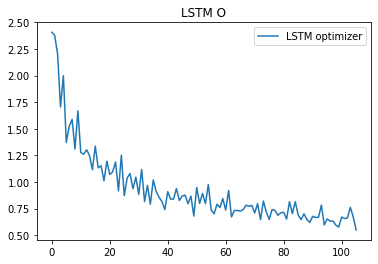

In [ ]:
plt.plot(model.step_training_losses, label='LSTM optimizer')
plt.legend()
plt.title("LSTM O")

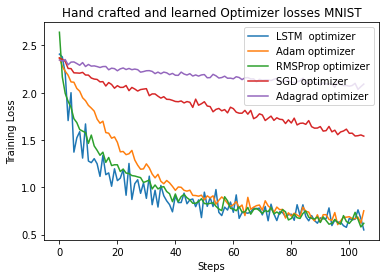

In [ ]:
def plot_steps_train_results():
  plt.plot(np.array(model.step_training_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_train_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_train_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_train_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_train_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Training Loss') 
  plt.title('Hand crafted and learned Optimizer losses MNIST')
  # show a legend on the plot
  plt.legend(loc=1)

def plot_steps_valid_results():
  plt.plot(np.array(model.step_validation_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_valid_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_valid_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_valid_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_valid_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Validation Loss') 
  plt.title('Hand crafted and learned Optimizer losses MNIST')
  # show a legend on the plot
  plt.legend(loc=1)

plot_steps_train_results()

Training loss for step 105: 0.7516, validation loss: 0.6530, validation accuracy: 0.7843: 100%|██████████| 106/106 

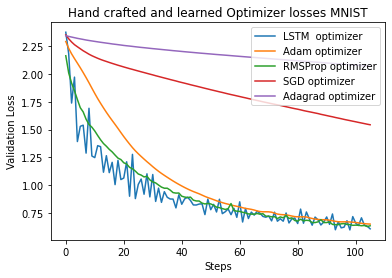

In [ ]:
plot_steps_valid_results()

## Accuracy for 20 - hidden units


In [ ]:
def print_accuracy_report(optimizer_name, test_y, preds):
    print(f"***** {optimizer_name} Accuracy metrics******")
    print(sm.classification_report(test_y, preds, target_names=class_names))
    print()

In [ ]:
def print_accuracy_reports():
  print_accuracy_report("LSTM_optimizer", test_y, np.argmax(lstm_optimizer_preds, axis=1))
  print_accuracy_report("Adagrad", test_y, np.argmax(adagrad_preds, axis=1))
  print_accuracy_report("RMSProp", test_y, np.argmax(rms_preds, axis=1))
  print_accuracy_report("ADAM", test_y, np.argmax(adam_preds, axis=1))
  print_accuracy_report("SGD", test_y, np.argmax(sgd_preds, axis=1))

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.73      0.80      0.76      1000
 Trouser/pants       0.94      0.95      0.95      1000
Pullover shirt       0.56      0.76      0.65      1000
         Dress       0.83      0.80      0.81      1000
          Coat       0.59      0.69      0.63      1000
        Sandal       0.85      0.88      0.86      1000
         Shirt       0.54      0.19      0.28      1000
       Sneaker       0.94      0.76      0.84      1000
           Bag       0.88      0.95      0.91      1000
    Ankle boot       0.82      0.94      0.88      1000

      accuracy                           0.77     10000
     macro avg       0.77      0.77      0.76     10000
  weighted avg       0.77      0.77      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.12      0.00      0.01      1000
 Trouser/pants    

## Train a model with 40 hidden units

In [ ]:
# Use the pretrained optimizer and check how it adapts on the 40 hidden size problem
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1)


Training loss for step 99: 0.4320 val_loss 0.6204 val_acc 0.807:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 0.5534 ,avg_val_loss: 0.7578 avg_val_acc: 0.7622, current_val_Acc 0.8068 



In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)


In [ ]:
train_model(train, epochs=1)

In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.5722, validation loss: 0.6749, validation accuracy: 0.7720: 100%|██████████| 106/106 



 Epoch 0: Train loss: 1.1097  Validation Loss: 1.0951, Validation Accuracy 0.7720
Start of epoch 1


Training loss for step 105: 0.5512, validation loss: 0.5416, validation accuracy: 0.8182: 100%|██████████| 106/106 



 Epoch 1: Train loss: 0.5937  Validation Loss: 0.5904, Validation Accuracy 0.8182
Start of epoch 0


Training loss for step 105: 0.7347, validation loss: 0.6897, validation accuracy: 0.7698:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.0326  Validation Loss: 1.0097, Validation Accuracy 0.7698
Start of epoch 1


Training loss for step 105: 0.5170, validation loss: 0.5404, validation accuracy: 0.8202: 100%|██████████| 106/106 



 Epoch 1: Train loss: 0.6091  Validation Loss: 0.6011, Validation Accuracy 0.8202
Start of epoch 0


Training loss for step 105: 1.6436, validation loss: 1.6829, validation accuracy: 0.4727:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.9583  Validation Loss: 1.9559, Validation Accuracy 0.4727
Start of epoch 1


Training loss for step 105: 1.3446, validation loss: 1.2874, validation accuracy: 0.6410: 100%|██████████| 106/106 



 Epoch 1: Train loss: 1.4716  Validation Loss: 1.4726, Validation Accuracy 0.6410
Start of epoch 0


Training loss for step 105: 2.1441, validation loss: 2.1458, validation accuracy: 0.1940:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 2.2235  Validation Loss: 2.2263, Validation Accuracy 0.1940
Start of epoch 1


Training loss for step 105: 2.0238, validation loss: 1.9958, validation accuracy: 0.2923: 100%|██████████| 106/106 


 Epoch 1: Train loss: 2.0636  Validation Loss: 2.0695, Validation Accuracy 0.2923


## Plot results for 40 hidden units 1 epoch 106 steps



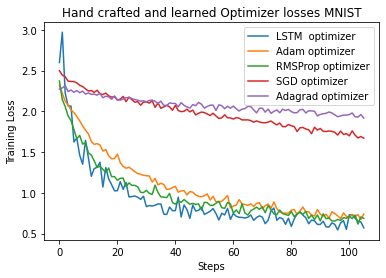

In [ ]:
plot_steps_train_results()

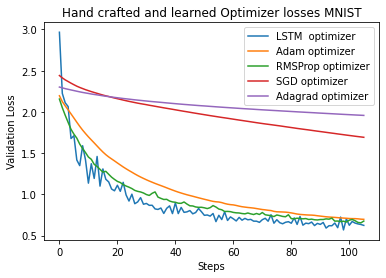

In [ ]:
plot_steps_valid_results()

## Plot Results with model that has 40 hidden units with optimizer trained for100steps

In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=2)
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=2)
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=2)
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=2)

In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=2)

Training loss for step 105: 0.6537 val_loss 0.6131 val_acc 0.776: 100%|██████████| 106/106 


 Epoch: 0 => loss: 0.9216 ,avg_val_loss: 0.8990 avg_val_acc: 0.6677, current_val_Acc 0.7763 



Training loss for step 105: 0.5185 val_loss 0.5163 val_acc 0.814: 100%|██████████| 106/106 


 Epoch: 1 => loss: 0.5822 ,avg_val_loss: 0.5775 avg_val_acc: 0.7826, current_val_Acc 0.8140 



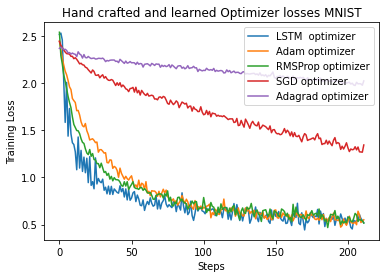

In [ ]:
plot_steps_train_results()

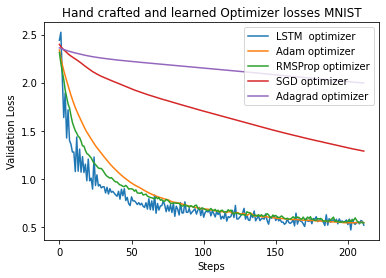

In [ ]:
plot_steps_valid_results()

### Accuracy results 

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.67      0.90      0.77      1000
 Trouser/pants       0.99      0.93      0.96      1000
Pullover shirt       0.82      0.52      0.64      1000
         Dress       0.83      0.88      0.85      1000
          Coat       0.63      0.82      0.71      1000
        Sandal       0.96      0.82      0.89      1000
         Shirt       0.65      0.41      0.50      1000
       Sneaker       0.92      0.81      0.87      1000
           Bag       0.90      0.97      0.93      1000
    Ankle boot       0.78      0.98      0.87      1000

      accuracy                           0.80     10000
     macro avg       0.81      0.80      0.80     10000
  weighted avg       0.81      0.80      0.80     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.62      0.03      0.05      1000
 Trouser/pants    

## Test training a model with Relu activation while optimizer is trained using Tanh activation

In [ ]:
# Use the pretrained optimizer and check how it adapts on the 40 hidden size problem
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 99: 0.4767 val_loss 0.6523 val_acc 0.801:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 0.6482 ,avg_val_loss: 0.8252 avg_val_acc: 0.7379, current_val_Acc 0.8007 



In [ ]:
# Use the pretrained optimizer and check how it adapts on Relu activation
model = MnistOptimizee(hidden_size=40, activation='relu')
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 1.9412 val_loss 1.8168 val_acc 0.603: 100%|██████████| 106/106 


 Epoch: 0 => loss: 1.6966 ,avg_val_loss: 1.6940 avg_val_acc: 0.5907, current_val_Acc 0.6027 



In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.8066, validation loss: 0.6764, validation accuracy: 0.7622: 100%|██████████| 106/106 



 Epoch 0: Train loss: 1.1702  Validation Loss: 1.1455, Validation Accuracy 0.7622
Start of epoch 0


Training loss for step 105: 0.6960, validation loss: 0.6686, validation accuracy: 0.7800: 100%|██████████| 106/106 



 Epoch 0: Train loss: 1.0139  Validation Loss: 0.9944, Validation Accuracy 0.7800
Start of epoch 0


Training loss for step 105: 1.5046, validation loss: 1.5102, validation accuracy: 0.5697:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.8553  Validation Loss: 1.8469, Validation Accuracy 0.5697
Start of epoch 0


Training loss for step 105: 1.9394, validation loss: 1.9496, validation accuracy: 0.2133: 100%|██████████| 106/106 


 Epoch 0: Train loss: 2.0676  Validation Loss: 2.0739, Validation Accuracy 0.2133


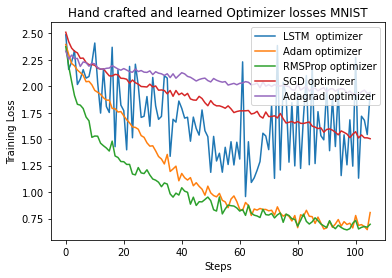

In [ ]:
plot_steps_train_results()

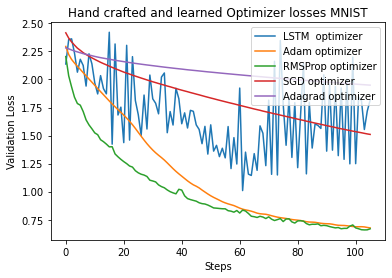

In [ ]:
plot_steps_valid_results()

## Train a model with sigmoid activation while trained on Tanh

In [ ]:
# Use the pretrained optimizer and check how it adapts on sigmoid activation while trained on tanh
model = MnistOptimizee(hidden_size=40, activation='sigmoid')
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.5756 val_loss 0.6116 val_acc 0.762:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.8745 ,avg_val_loss: 0.8491 avg_val_acc: 0.7024, current_val_Acc 0.7625 



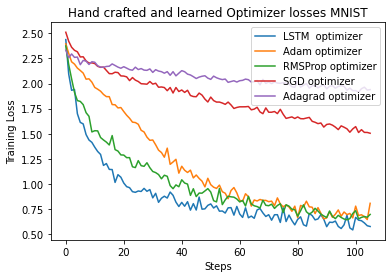

In [ ]:
plot_steps_train_results()

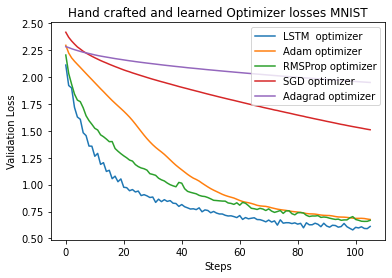

In [ ]:
plot_steps_valid_results()

### Accuracy results

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.67      0.90      0.77      1000
 Trouser/pants       0.99      0.93      0.96      1000
Pullover shirt       0.82      0.52      0.64      1000
         Dress       0.83      0.88      0.85      1000
          Coat       0.63      0.82      0.71      1000
        Sandal       0.96      0.82      0.89      1000
         Shirt       0.65      0.41      0.50      1000
       Sneaker       0.92      0.81      0.87      1000
           Bag       0.90      0.97      0.93      1000
    Ankle boot       0.78      0.98      0.87      1000

      accuracy                           0.80     10000
     macro avg       0.81      0.80      0.80     10000
  weighted avg       0.81      0.80      0.80     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.62      0.03      0.05      1000
 Trouser/pants    